# MLxtend: A Python Library with interesting tools for data science tasks

MLxtend library (Machine Learning extensions) has many interesting functions for everyday data analysis and machine learning tasks…



In [3]:
import pandas as pd

# Load wine data set (available at https://www.kaggle.com/tug004/3wine-classification-dataset)
df = pd.read_csv(r"D:\Dropbox\DS & AI\Full stack DS and AI course\25 June\wine.csv")

# Target values (wine classes) in y
y_s = df["Wine"].map({1: 0, 2: 1, 3: 2})  # Convert classes 1, 2, 3 to 0, 1, 2 to avoid strange behavior 
y = y_s.values

# Feature columns 
X_df = df.drop(columns=["Wine"])
X = X_df.values
attribute_names = X_df.columns

# MLxtend Functionalities
## Create Counterfactual (for model interpretability)

For creating counterfactual records (in the context of machine learning), we need to modify the features of some records from the training set in order to change the model prediction [2]. This may be helpful in explaining the behavior of a trained model. The algorithm used in the library to create counterfactual records is developed by Wachter et al [3].

You can create counterfactual records using _createcounterfactual() from the library. Note that this implementation works with any scikit-learn estimator that supports the predict() function. Below is an example of creating a counterfactual record for an ML model. The counterfactual record is highlighted in a red dot within the classifier’s decision regions (we will go over how to draw decision regions of classifiers later in the post).

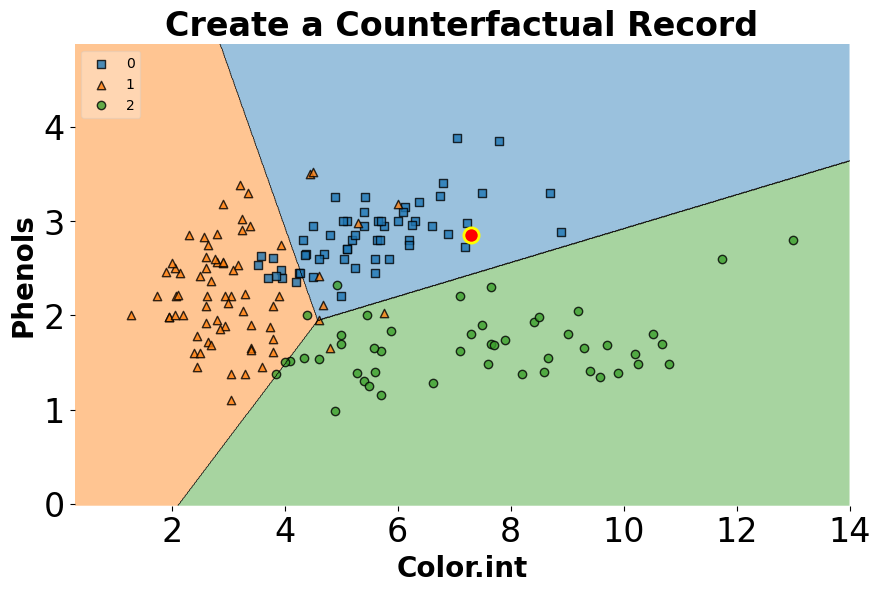

In [6]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import create_counterfactual
from mlxtend.plotting import plot_decision_regions

# Select two features for visualization
X_2d = X_df[["Color.int", "Phenols"]].values

# Import and train a model
from sklearn.linear_model import LogisticRegression
clf_logistic_regression = LogisticRegression(random_state=0)
clf_logistic_regression.fit(X_2d, y)

counterfact = create_counterfactual(
    x_reference=X_2d[15], 
    y_desired=2, # Desired class
    model=clf_logistic_regression, 
    X_dataset=X_2d,
    y_desired_proba=0.95,
    lammbda=1, 
    random_seed=123
)

scatter_highlight_defaults = {
    'c': 'red',
    'edgecolor': 'yellow',
    'alpha': 1.0,
    'linewidths': 2,
    'marker': 'o',
    's': 120
}


fig, ax = plt.subplots(figsize=(10, 6))
plot_decision_regions(X_2d, y, clf=clf_logistic_regression, legend=2, ax=ax)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_title("Create a Counterfactual Record", fontsize=24, fontweight="bold")
ax.set_xlabel("Color.int", fontsize=20, fontweight="bold")
ax.set_ylabel("Phenols", fontsize=20, fontweight="bold")

ax.scatter(
    *counterfact,
    **scatter_highlight_defaults
)

## PCA Correlation Circle

An interesting and different way to look at PCA results is through a correlation circle that can be plotted using _plot_pca_correlation_graph()_. We basically compute the correlation between the original dataset columns and the PCs (principal components). Then, these correlations are plotted as vectors on a unit-circle. The axes of the circle are the selected dimensions (a.k.a. PCs). You can specify the PCs you’re interested in by passing them as a tuple to dimensions function argument. The correlation circle axes labels show the percentage of the explained variance for the corresponding PC [1].

Remember that the normalization is important in PCA because the PCA projects the original data on to the directions that maximize the variance.

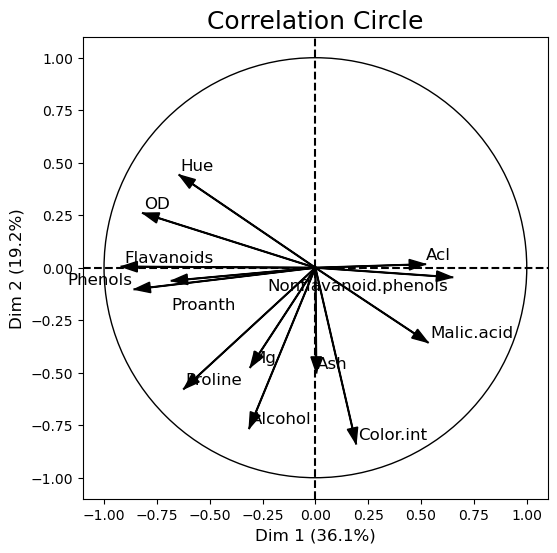

In [7]:
from mlxtend.plotting import plot_pca_correlation_graph
from sklearn.preprocessing import StandardScaler
X_norm = StandardScaler().fit_transform(X) # Normalizing the feature columns is recommended (X - mean) / std
fig, correlation_matrix = plot_pca_correlation_graph(
    X_norm, 
    attribute_names,
    dimensions=(1, 2),
    figure_axis_size=6
)

## Bias-Variance Decomposition

You often hear about the bias-variance tradeoff to show the model performance. In supervised learning, the goal often is to minimize both the bias error (to prevent underfitting) and variance (to prevent overfitting) so that our model can generalize beyond the training set [4]. This process is known as a bias-variance tradeoff.

Note that we cannot calculate the actual bias and variance for a predictive model, and the bias-variance tradeoff is a concept that an ML engineer should always consider and tries to find a sweet spot between the two. Having said that, we can still study the model’s expected generalization error for certain problems. In particular, we can use the bias-variance decomposition to decompose the generalization error into a sum of 1) bias, 2) variance, and 3) irreducible error [4, 5].

The bias-variance decomposition can be implemented through _bias_variance_decomp()_ in the library. An example of such implementation for a decision tree classifier is given below.

In [8]:
from mlxtend.evaluate import bias_variance_decomp

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df.values, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True,
                                                    stratify=y)
tree = DecisionTreeClassifier(random_state=123)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        tree, X_train, y_train, X_test, y_test, 
        loss='mse',
        num_rounds=50, # Number of bootstrap rounds for implementing the decomposition
        random_seed=123
)
print(f"Average expected loss: {avg_expected_loss.round(3)}")
print(f"Average bias: {avg_bias.round(3)}")
print(f"Average variance: {avg_var.round(3)}")

Average expected loss: 0.108
Average bias: 0.032
Average variance: 0.076


## Plotting Decision Regions of Classifiers

MLxtend library has an out-of-the-box function _plot_decision_regions()_ to draw a classifier’s decision regions in 1 or 2 dimensions.

Here, I will draw decision regions for several scikit-learn as well as MLxtend models. Let’s first import the models and initialize them.

In [9]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from mlxtend.classifier import EnsembleVoteClassifier 

# Initializing Classifiers
clf_logistic_regression = LogisticRegression(random_state=0)
clf_nb = GaussianNB()
clf_random_forest = RandomForestClassifier(random_state=0)
clf_ensemble = EnsembleVoteClassifier(
    clfs=[clf_logistic_regression, clf_nb, clf_random_forest], 
    weights=[2, 1, 1], 
    voting='soft'
)

all_classifiers = [
    ("Logistic Regression", clf_logistic_regression),
    ("Naive Bayes", clf_nb),
    ("Random Forest", clf_random_forest),
    ("Ensemble", clf_ensemble),
]

Now that we have initialized all the classifiers, let’s train the models and draw decision boundaries using _plot_decision_regions()_ from the MLxtend library.

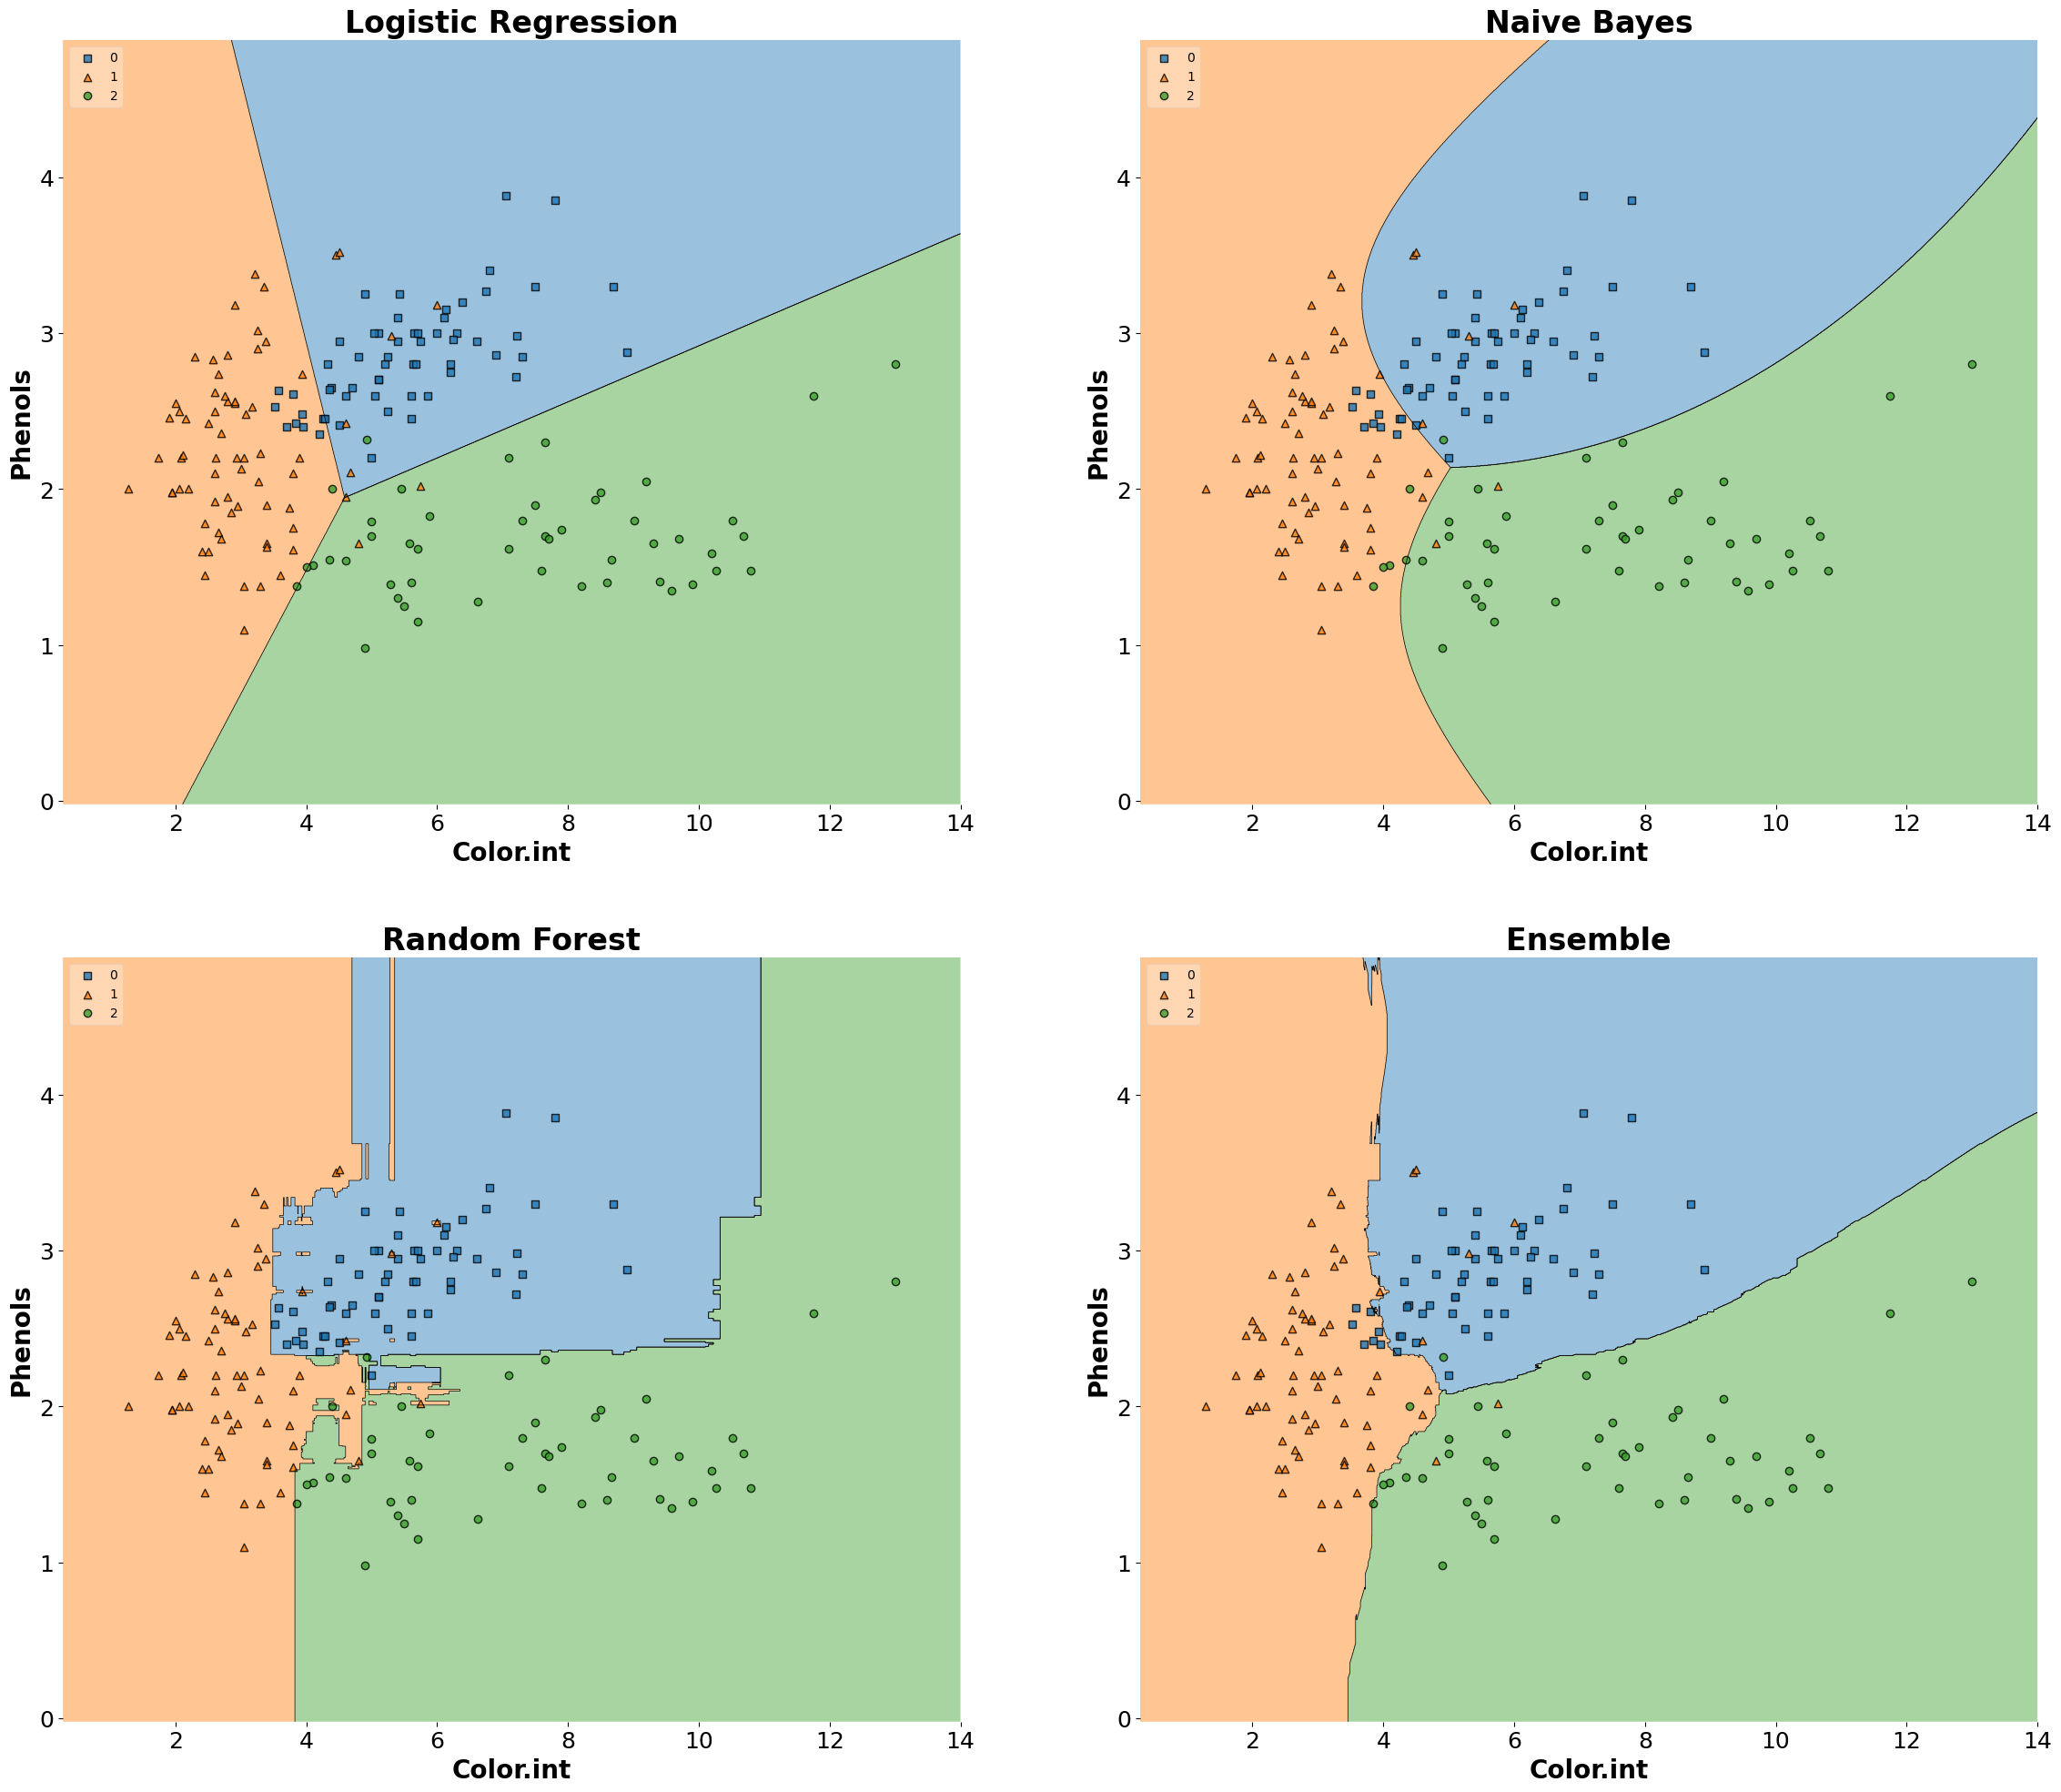

In [10]:
from mlxtend.plotting import plot_decision_regions
from itertools import product  # Used to generate indices for figure subplots!

fig, axs = plt.subplots(2, 2, figsize=(28, 24), sharey=True)

for classifier, grid in zip(
    all_classifiers,
    product([0, 1], [0, 1])  # generate [(0, 0), (0, 1), (1, 0), (1, 1)]
):
    clf_name, clf = classifier[0], classifier[1]
    ax = axs[grid[0], grid[1]]

    clf.fit(X_2d, y)
    
    plot_decision_regions(
        X=X_2d, 
        y=y, 
        clf=clf, 
        legend=2, 
        ax=ax
    )

    ax.set_title(clf_name, fontsize=24, fontweight="bold")
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xlabel("Color.int", fontsize=20, fontweight="bold")
    ax.set_ylabel("Phenols", fontsize=20, fontweight="bold")

## Matrix of Scatter Plots

Another useful tool from MLxtend is the ability to draw a matrix of scatter plots for features (using _scatterplotmatrix()_). In order to add another dimension to the scatter plots, we can also assign different colors for different target classes.

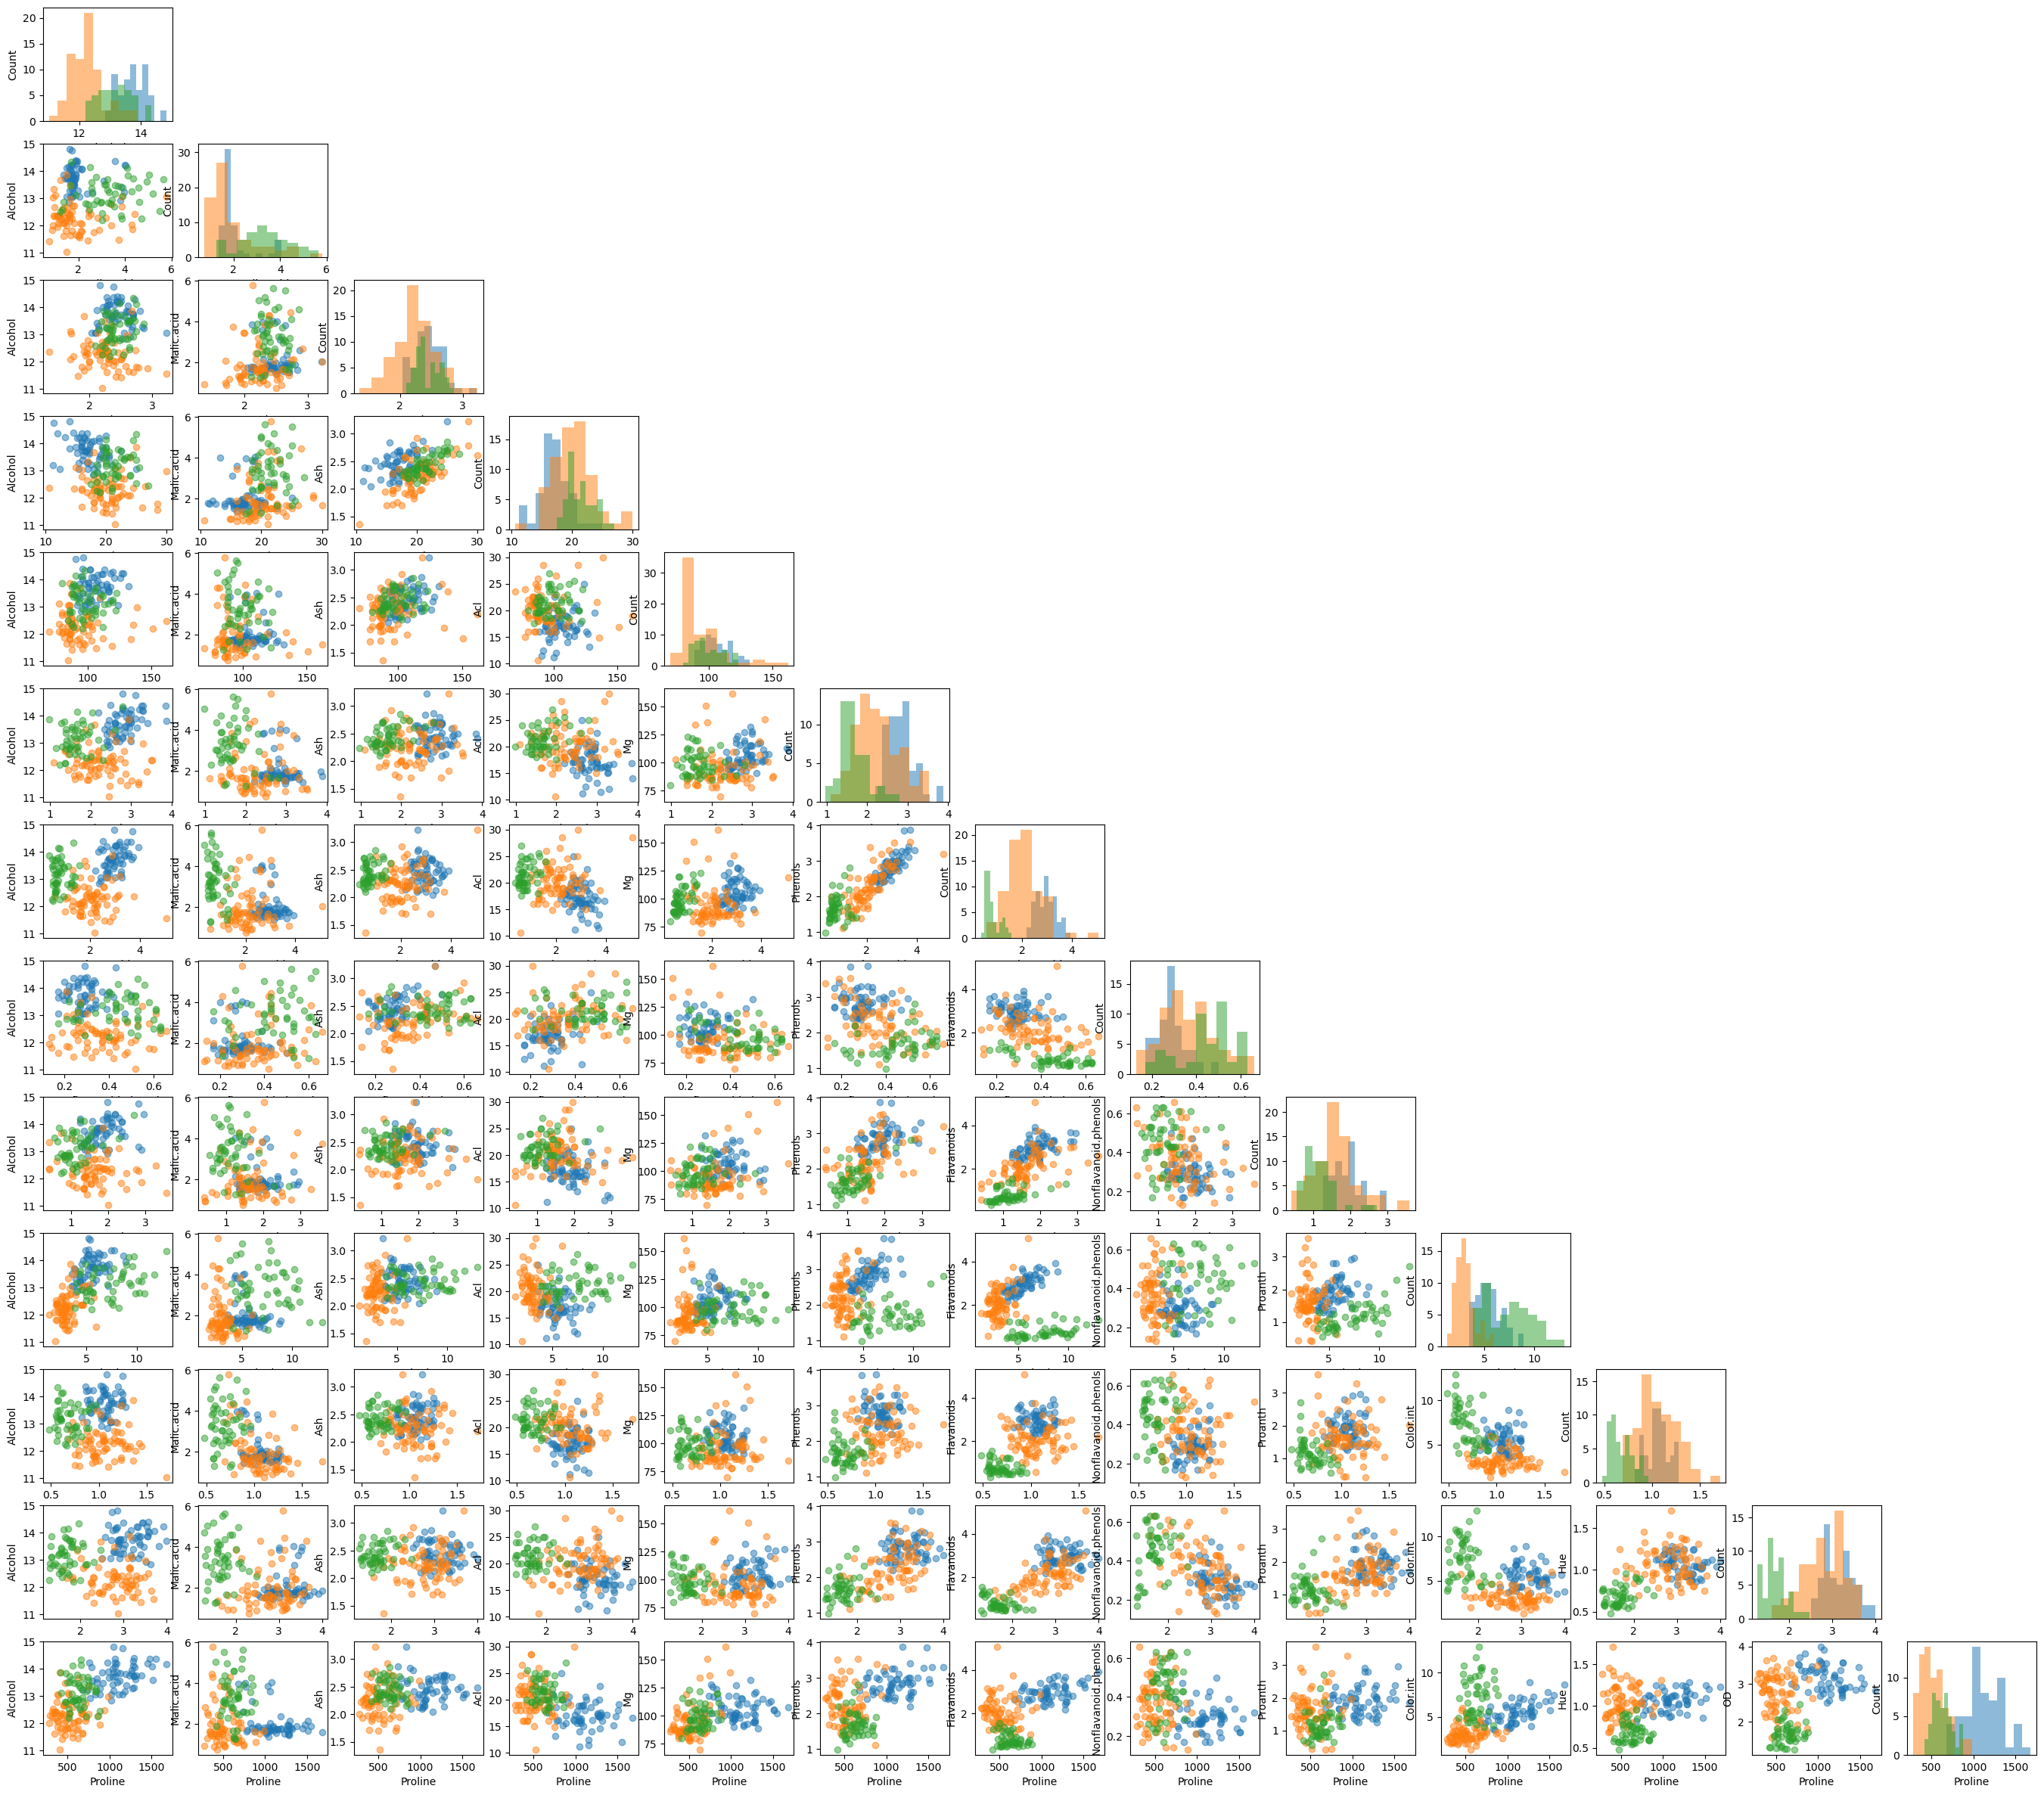

In [11]:
from mlxtend.plotting import scatterplotmatrix

fig, axes = scatterplotmatrix(X[y==0], figsize=(34, 30), alpha=0.5)
fig, axes = scatterplotmatrix(X[y==1], fig_axes=(fig, axes), alpha=0.5)
fig, axes = scatterplotmatrix(X[y==2], fig_axes=(fig, axes), alpha=0.5, names=attribute_names)

## Bootstrapping

The bootstrap is an easy way to estimate a sample statistic and generate the corresponding confidence interval by drawing random samples with replacement. For this, you can use the function _bootstrap()_ from the library. Note that you can pass a custom statistic to the bootstrap function through argument func. The custom function must return a scalar value.

In [12]:
import numpy as np
from mlxtend.evaluate import bootstrap

# Generating 100 random data with a mean of 5
random_data = np.random.RandomState(123).normal(loc=5., size=100)

avg, std_err, ci_bounds = bootstrap(
    random_data, 
    num_rounds=1000, 
    func=np.mean,  # A function to compute a sample statistic can be passed here
    ci=0.95, 
    seed=123
)

print(
    f"Mean: {avg.round(2)} \n"
    f"Standard Error: +/- {std_err.round(2)} \n"
    f"CI95: [{ci_bounds[0].round(2)}, {ci_bounds[1].round(2)}]"
)

Mean: 5.03 
Standard Error: +/- 0.11 
CI95: [4.8, 5.26]


## Conclusion

In this post, we went over several MLxtend library functionalities, in particular, we talked about creating counterfactual instances for better model interpretability and plotting decision regions for classifiers, drawing PCA correlation circle, analyzing bias-variance tradeoff through decomposition, drawing a matrix of scatter plots of features with colored targets, and implementing the bootstrapping. The library is a nice addition to your data science toolbox, and I recommend giving this library a try.

Sources:

https://towardsdatascience.com/mlxtend-a-python-library-with-interesting-tools-for-data-science-tasks-d54c723f89cd/

https://ealizadeh.com/blog/mlxtend-library-for-data-science/